**План проекта**

*   Обработка данных ++
*   Анализ данных++
*   Линейна регрессия ++
*   График анализ результатов++
*   Градиентный Бустинг ++
*   Анализ результатов, Визуализация++



In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Загрузка и обработка данных**

In [37]:
import zipfile

with zipfile.ZipFile('archive(1).zip', 'r') as zip_ref:
    zip_ref.extractall()

In [38]:
df = pd.read_csv('games.csv')
df.head()

,title,platforms,rating,votes,developer,release_date,price,genres,url
0,Call of Duty®: Modern Warfare® III - Cross-Gen...,"['PS4', 'PS5']",4.04,334075,Activision,2023-11-02,45.49,['Action'],https://store.playstation.com/en-us/concept/10...
1,Fortnite,['PS5'],4.32,6876621,Epic Games,2017-07-21,0.00,"['Action', 'Adventure']",https://store.playstation.com/en-us/concept/22...
2,NBA 2K24 Kobe Bryant Edition for PS5™,"['PS4', 'PS5']",3.01,33433,2K,2023-09-08,10.49,['Sport'],https://store.playstation.com/en-us/concept/10...
3,Destiny 2 PS4™ & PS5™,"['PS4', 'PS5']",4.28,292806,Bungie,2020-12-08,0.00,"['Shooter', 'Adventure', 'Action']",https://store.playstation.com/en-us/concept/22...
4,EA SPORTS FC™ 24 Standard Edition PS4 & PS5,"['PS4', 'PS5']",3.25,87378,Electronic Arts Inc,2023-09-29,69.99,['Sport'],https://store.playstation.com/en-us/concept/10...


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8981 entries, 0 to 8980
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         8981 non-null   object 
 1   platforms     8981 non-null   object 
 2   rating        8981 non-null   float64
 3   votes         8981 non-null   int64  
 4   developer     8981 non-null   object 
 5   release_date  8981 non-null   object 
 6   price         8981 non-null   float64
 7   genres        8981 non-null   object 
 8   url           8981 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 631.6+ KB


In [40]:
df.isna().max()

,0
title,False
platforms,False
rating,False
votes,False
developer,False
release_date,False
price,False
genres,False
url,False


В данных нет пропусков, спасибо автору!

Удаляем сложнообрабатываемы данные. Приэтом мы, к сожалению, теряем графу название, в который может крыться причина успеха вторых частей игр. Обработаем даты год, месяц (в форме синуса-косинуса, так как это периодический признак)

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast


df = df.drop(columns={'url' , 'title'})
X = df
y = df['rating']
z = df['votes']

X['date'] = pd.to_datetime(X['release_date'])
X['year'] = X['date'].dt.year - 2010
X['month'] = X['date'].dt.month
X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)



mlbp = MultiLabelBinarizer()
mlbg = MultiLabelBinarizer()
X['genres'] = X['genres'].apply(ast.literal_eval)
X['platforms'] = X['platforms'].apply(ast.literal_eval)
platforms_encoded =  pd.DataFrame(mlbp.fit_transform(X['platforms']), columns=mlbp.classes_, index=df.index)
genres_encoded =  pd.DataFrame(mlbg.fit_transform(X['genres']), columns=mlbg.classes_, index=df.index)
X = pd.concat([df, platforms_encoded, genres_encoded], axis=1)

X = X.drop(columns={'genres', 'platforms','rating', 'votes', 'month', 'date', 'release_date'})

X.head()

,developer,price,year,month_sin,month_cos,PS4,PS5,Action,Adult,Adventure,...,Party,Puzzle,Quiz,Role Playing Games,Shooter,Simulation,Simulator,Sport,Strategy,Unique
0,Activision,45.49,13,-5.000000e-01,8.660254e-01,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Epic Games,0.00,7,-5.000000e-01,-8.660254e-01,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2K,10.49,13,-1.000000e+00,-1.836970e-16,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Bungie,0.00,10,-2.449294e-16,1.000000e+00,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
4,Electronic Arts Inc,69.99,13,-1.000000e+00,-1.836970e-16,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.15, random_state=42)

In [43]:
developer_counts = X_train['developer'].value_counts()
X_train['developer_freq'] = X_train['developer'].map(developer_counts)
developer_counts.to_dict()

X_test['developer_freq'] = [developer_counts.get(x, 0) for x in X_test['developer']]
X_test = X_test.drop(columns=['developer'])
X_train = X_train.drop(columns=['developer'])

Применяем частототное кодирование, потому что различных developers очень много, при предсказание легко посчитать кол-во игр вышедших у этой компании, так же для улчшения модели можно добавить признак как средене рейтиногов у прошлых игр этой компании за n последние лет.

In [44]:
X_train

,price,year,month_sin,month_cos,PS4,PS5,Action,Adult,Adventure,Arcade,...,Puzzle,Quiz,Role Playing Games,Shooter,Simulation,Simulator,Sport,Strategy,Unique,developer_freq
8864,12.99,13,-5.000000e-01,-0.866025,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,24
3395,19.99,6,-5.000000e-01,0.866025,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,43
3299,14.99,13,5.000000e-01,-0.866025,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,21
3459,9.99,6,-8.660254e-01,-0.500000,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,76
6119,19.99,13,-8.660254e-01,0.500000,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,4.99,8,8.660254e-01,0.500000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5
5191,0.00,12,-8.660254e-01,0.500000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,61
5390,5.99,12,-2.449294e-16,1.000000,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,58
860,19.99,14,5.000000e-01,-0.866025,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,17


**Анализ данных:**

In [45]:
import seaborn as sns

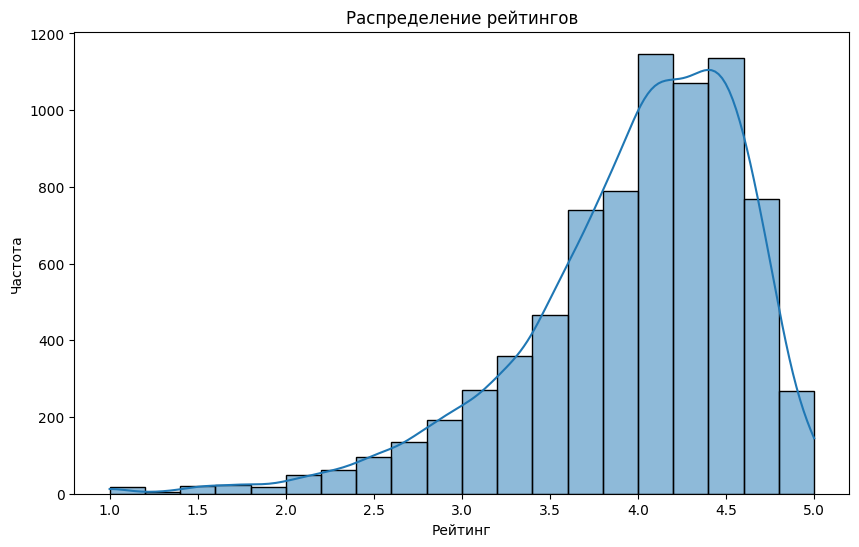

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=20)
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.show()

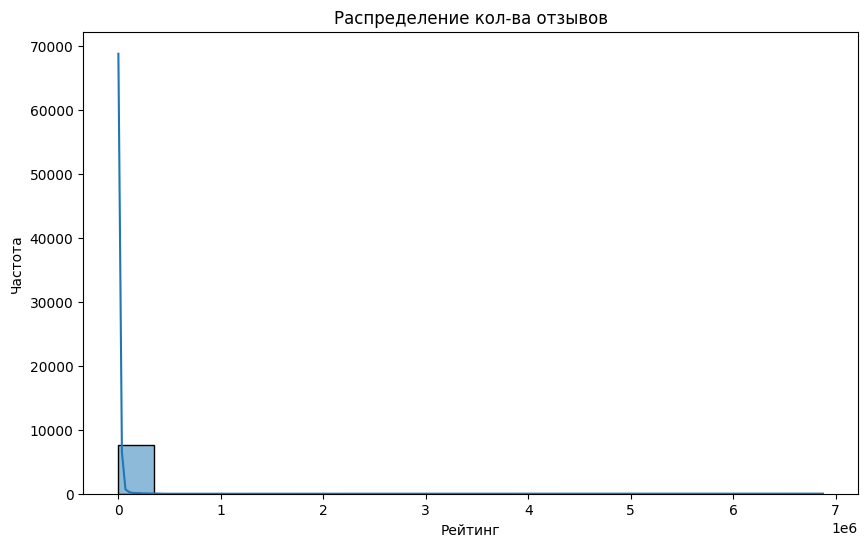

In [47]:
plt.figure(figsize=(10, 6))
sns.histplot(z_train, kde=True, bins=20)
plt.title('Распределение кол-ва отзывов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.show()

Почти половина игра имеет рейтинг в интервале (4.0-4.5)

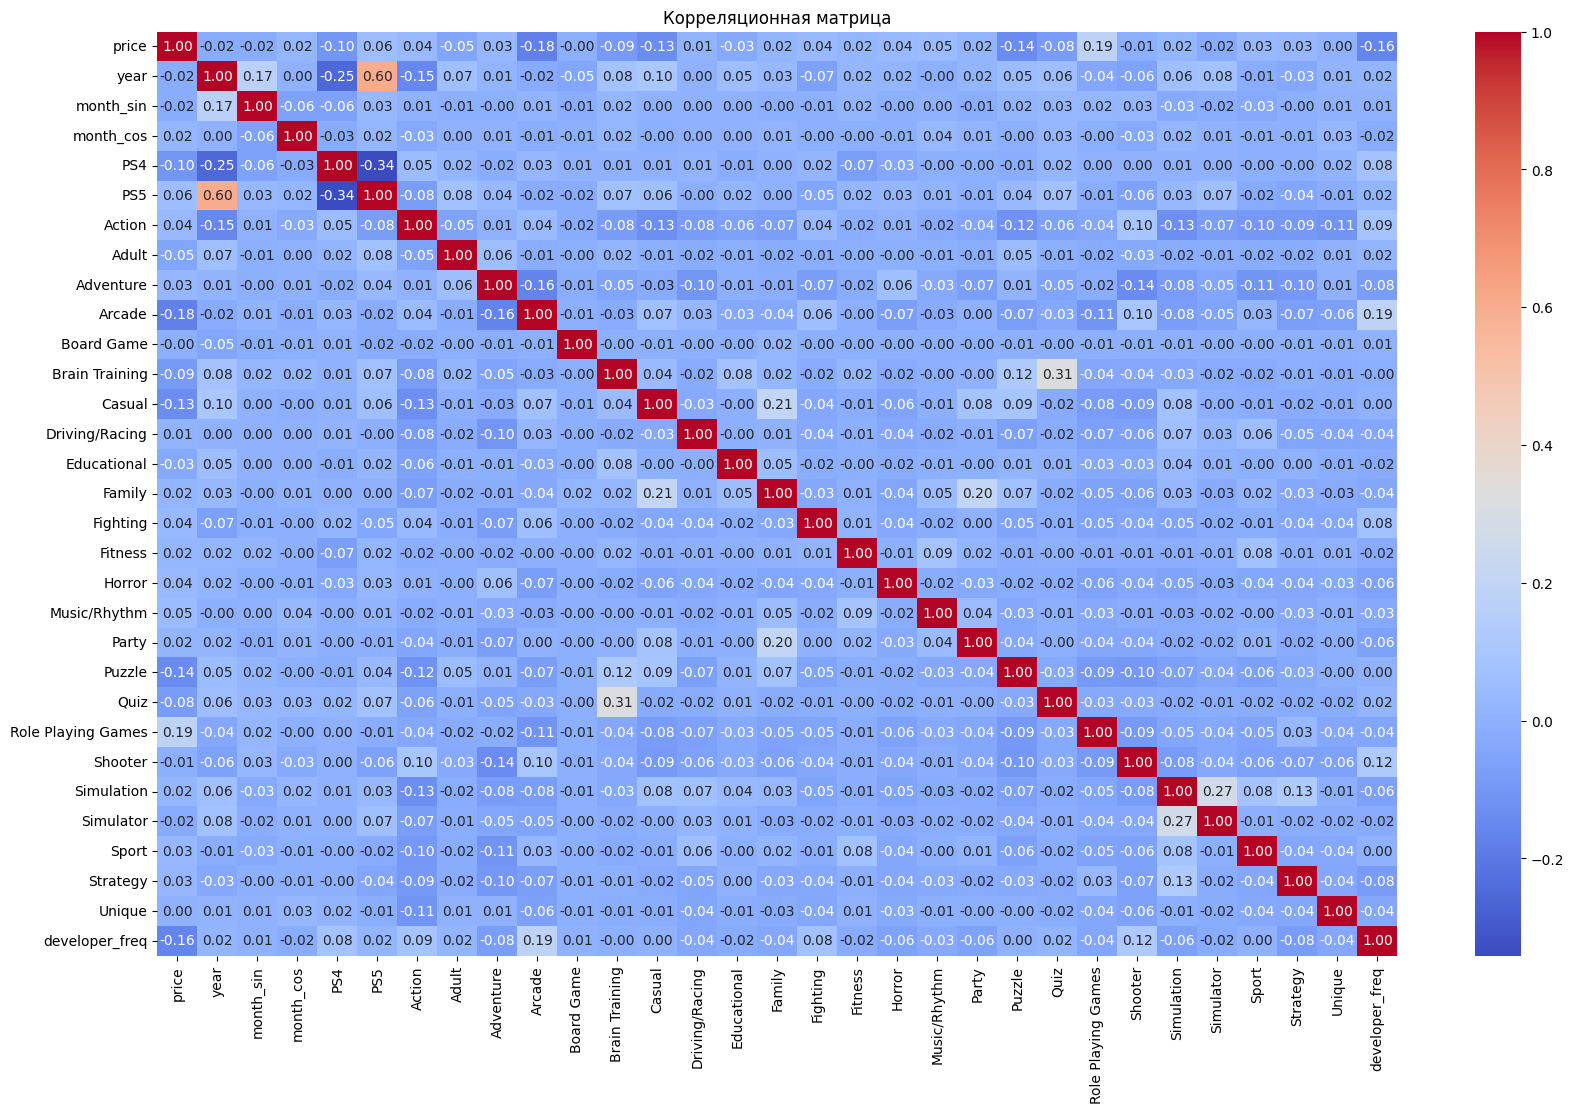

In [48]:
corr = X_train.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

Большие корреляции у года и Ps_5 (так как PS_5 вышла недавно), у Quiz и Brain Training. Странная корреляция у синуса месяца и год, это забавно))

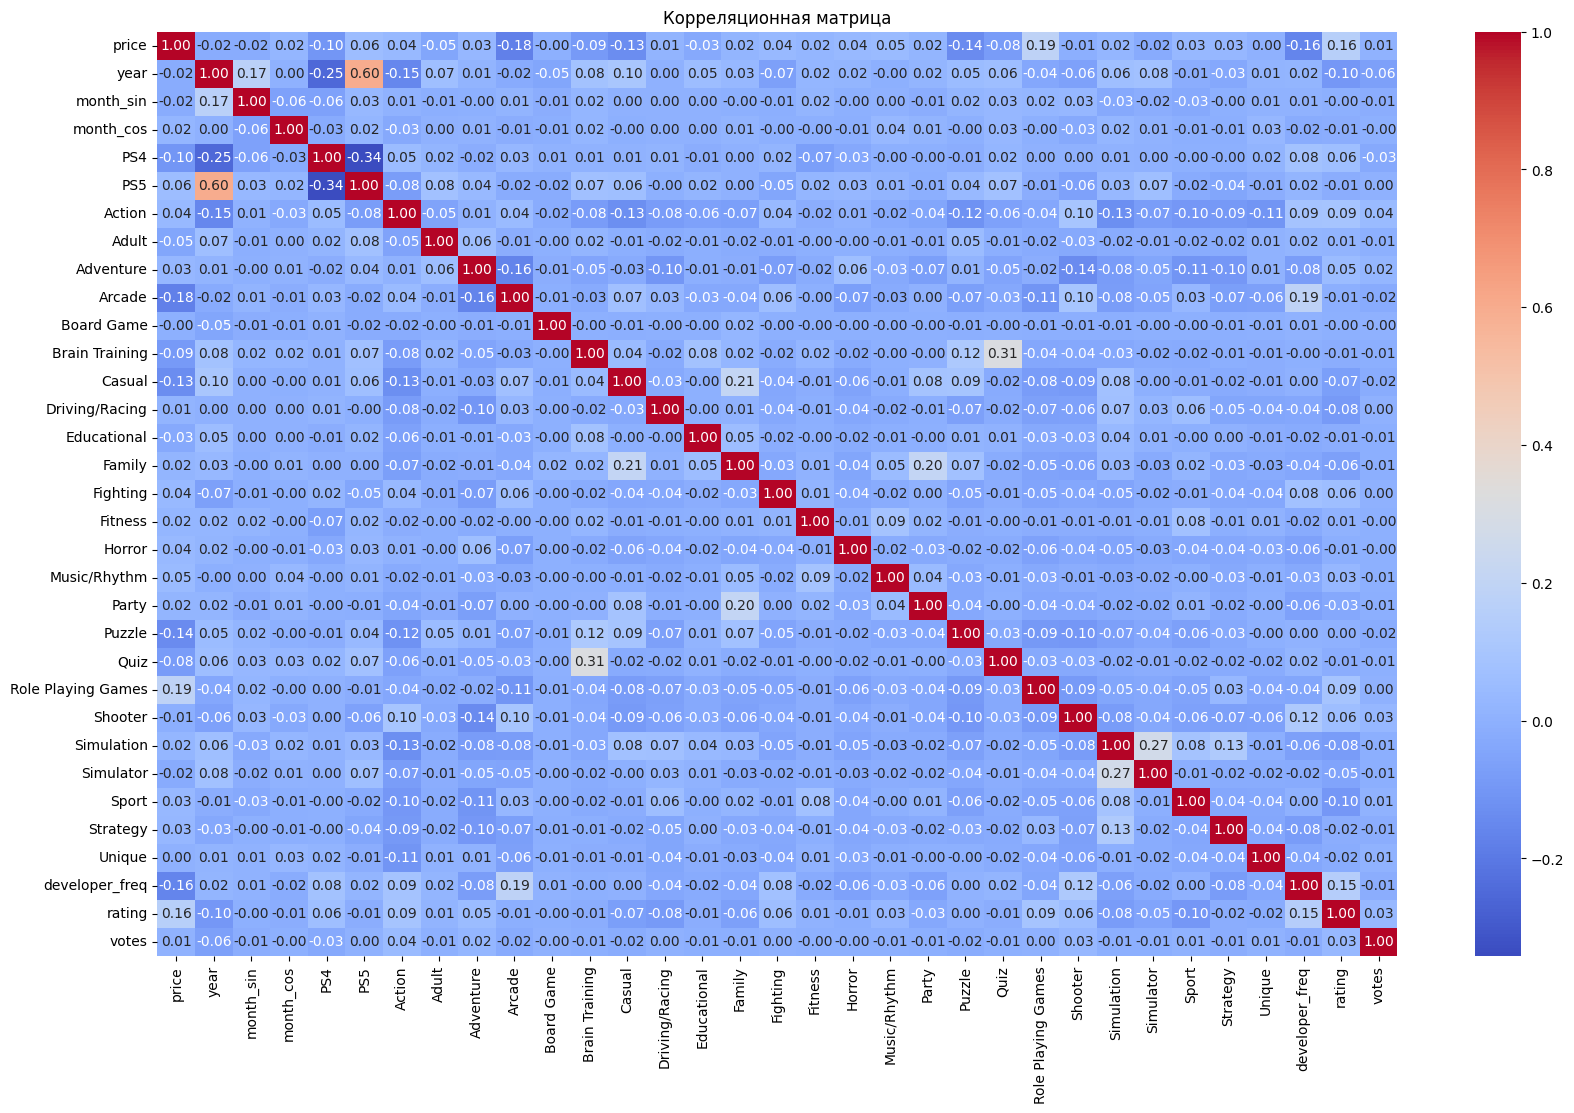

In [49]:
G = pd.concat([X_train, y_train, z_train], axis=1)

corr = G.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

**Первая модель --- Простая линейная регрессия **


Выводы:
1) Рейтинг. Сильно зависит от цены, года (но не от месяца, то есть нет сезонности), актвиности компании, еще для категорий RolePlaying game, Sport, DrivingRacing.
2) Кол-во отзывов (~популярность). удивительно что некоррелирован с ценой!!, единственная немаленькая корреляция с годом

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


modely = LinearRegression()
modely.fit(X_train, y_train)
y_test_pred = modely.predict(X_test)

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y MAPE: {mape_test:.4f}')
print(f'Test y RMSE: {rmse_test:.4f}')

modelz = LinearRegression()
modelz.fit(X_train, z_train)
z_test_pred = modelz.predict(X_test)

mape_test = mean_absolute_percentage_error(z_test, z_test_pred)
rmse_test = np.sqrt(mean_squared_error(z_test, z_test_pred))
print(f'Test z MAPE: {mape_test:.4f}')
print(f'Test z RMSE: {rmse_test:.4f}')

Test y MAPE: 0.1394
Test y RMSE: 0.6128
Test z MAPE: 266.8050
Test z RMSE: 27398.9408


In [51]:
z_train_pred = modelz.predict(X_train)
mape_test = mean_absolute_percentage_error(z_train, z_train_pred)
rmse_test = np.sqrt(mean_squared_error(z_train, z_train_pred))
print(f'Test z MAPE: {mape_test:.4f}')
print(f'Test z RMSE: {rmse_test:.4f}')

y_train_pred = modely.predict(X_train)
mape_test = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Test y MAPE: {mape_test:.4f}')
print(f'Test y RMSE: {rmse_test:.4f}')

Test z MAPE: 276.1577
Test z RMSE: 85556.6565
Test y MAPE: 0.1372
Test y RMSE: 0.6057


In [52]:
z_test_pred = pd.Series(z_test_pred, index=y_test.index)

In [53]:
X_test[np.abs(z_test_pred - z_test) > 100000]

,price,year,month_sin,month_cos,PS4,PS5,Action,Adult,Adventure,Arcade,...,Puzzle,Quiz,Role Playing Games,Shooter,Simulation,Simulator,Sport,Strategy,Unique,developer_freq
315,19.99,6,-8.660254e-01,0.500000,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,42
14,0.00,12,8.660254e-01,0.500000,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,42
586,0.00,5,1.224647e-16,-1.000000,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,2
50,39.99,14,5.000000e-01,0.866025,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,148
149,5.99,7,-5.000000e-01,0.866025,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,42
17,19.99,14,5.000000e-01,-0.866025,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,87
601,0.00,5,8.660254e-01,0.500000,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,38
1488,14.99,5,-5.000000e-01,-0.866025,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,148
132,0.00,8,-2.449294e-16,1.000000,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
0,45.49,13,-5.000000e-01,0.866025,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,16


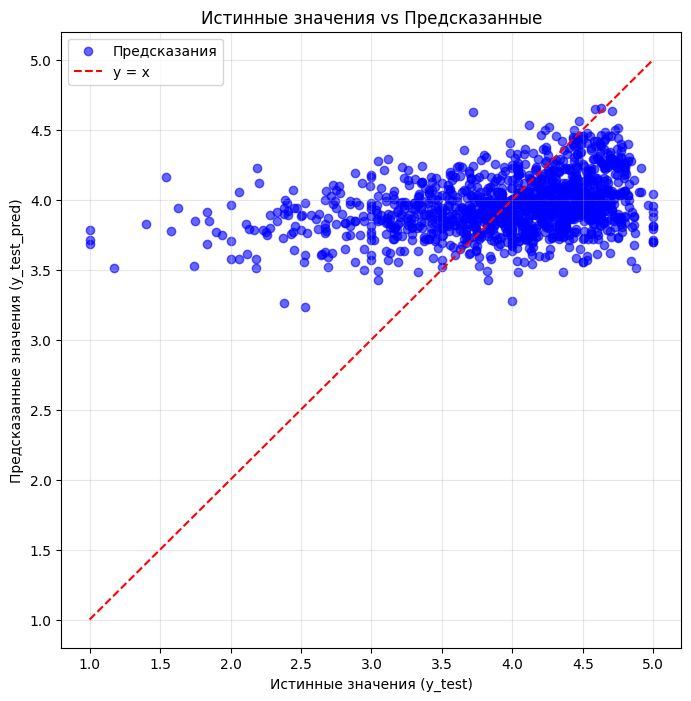

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Предсказания')

max_val = max(max(y_test), max(y_test_pred))
min_val = min(min(y_test), min(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

plt.title('Истинные значения vs Предсказанные')
plt.xlabel('Истинные значения (y_test)')
plt.ylabel('Предсказанные значения (y_test_pred)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

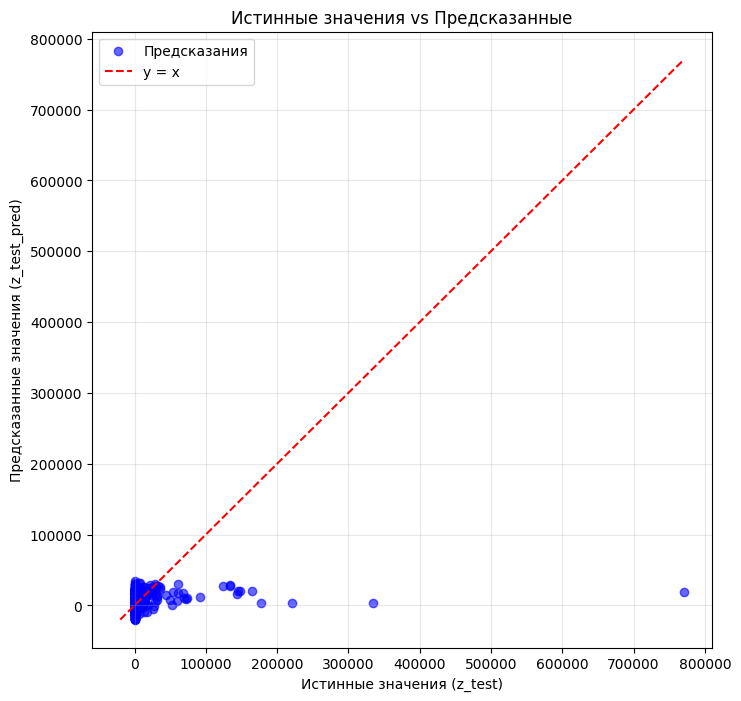

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(z_test, z_test_pred, alpha=0.6, color='blue', label='Предсказания')

max_val = max(max(z_test), max(z_test_pred))
min_val = min(min(z_test), min(z_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

plt.title('Истинные значения vs Предсказанные')
plt.xlabel('Истинные значения (z_test)')
plt.ylabel('Предсказанные значения (z_test_pred)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

CatBoost

In [56]:
!pip install catboost

In [57]:
X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(X_train, y_train, z_train, test_size=0.1, random_state=42)

In [58]:
from lightgbm import LGBMRegressor

model_y = LGBMRegressor(n_estimators=40, learning_rate=0.1, max_depth=6, random_state=42)
model_z = LGBMRegressor(n_estimators=40, learning_rate=0.1, max_depth=6, random_state=42)
model_y.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')
y_test_pred = model_y.predict(X_test)
y_train_pred = model_y.predict(X_train)
model_z.fit(X_train, z_train, eval_set=[(X_val, z_val)], eval_metric='rmse')
z_test_pred = model_z.predict(X_test)
z_train_pred = model_z.predict(X_train)

mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Train y MAPE: {mape_train:.4f}')
print(f"Train y RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test y MAPE: {mape_test:.4f}')
print(f"Test y RMSE: {rmse_test:.4f}")

mape_train = mean_absolute_percentage_error(z_train, z_train_pred)
rmse_train = np.sqrt(mean_squared_error(z_train, z_train_pred))
print(f'Train z MAPE: {mape_train:.4f}')
print(f"Train z RMSE: {rmse_train:.4f}")

mape_test = mean_absolute_percentage_error(z_test, z_test_pred)
rmse_test = np.sqrt(mean_squared_error(z_test, z_test_pred))
print(f'Test z MAPE: {mape_test:.4f}')
print(f"Test z RMSE: {rmse_test:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 6869, number of used features: 29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3.970319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001986 seconds.
You can set `force_row_wise

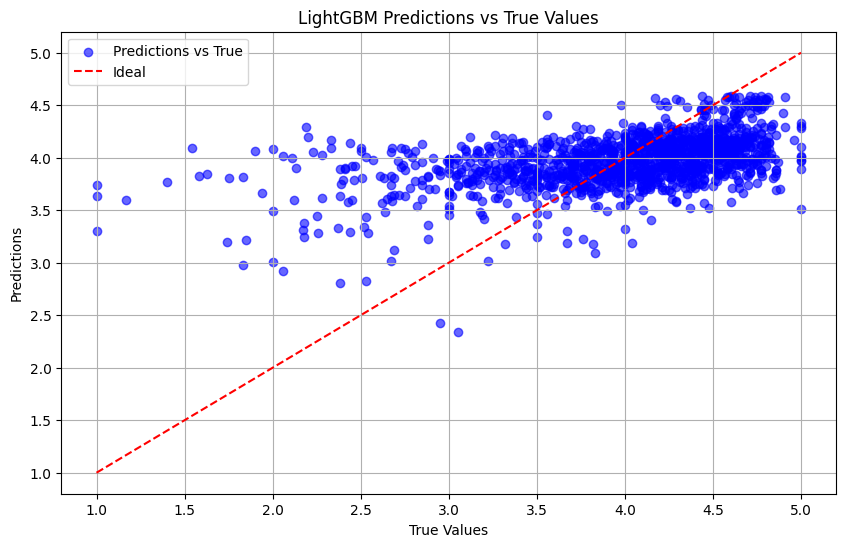

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Predictions vs True')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('LightGBM Predictions vs True Values')
plt.legend()
plt.grid()
plt.show()

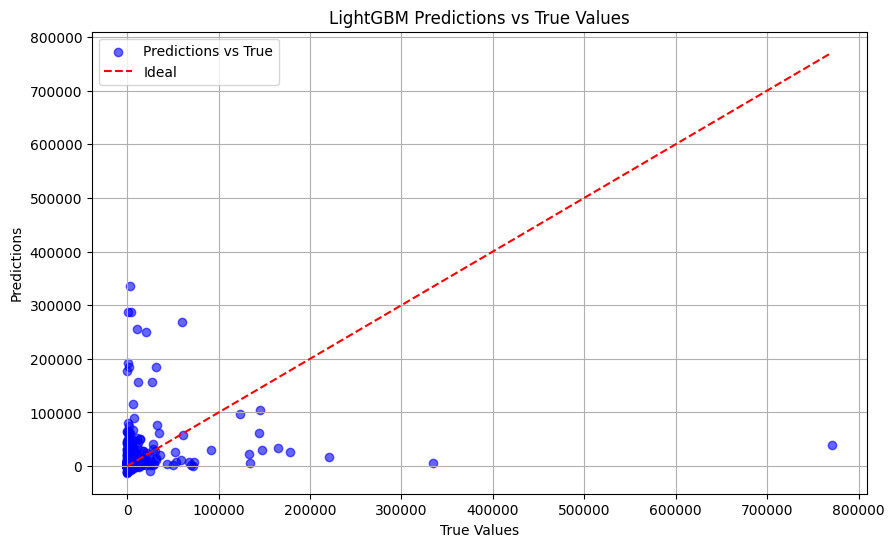

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(z_test, z_test_pred, alpha=0.6, color='blue', label='Predictions vs True')
plt.plot([min(z_test), max(z_test)], [min(z_test), max(z_test)], color='red', linestyle='--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('LightGBM Predictions vs True Values')
plt.legend()
plt.grid()
plt.show()

Гардиентый бустинг показал лучшие результаты по сранвению с самой базовой Линейной регрессией. Посмотрим ее важность признаков.

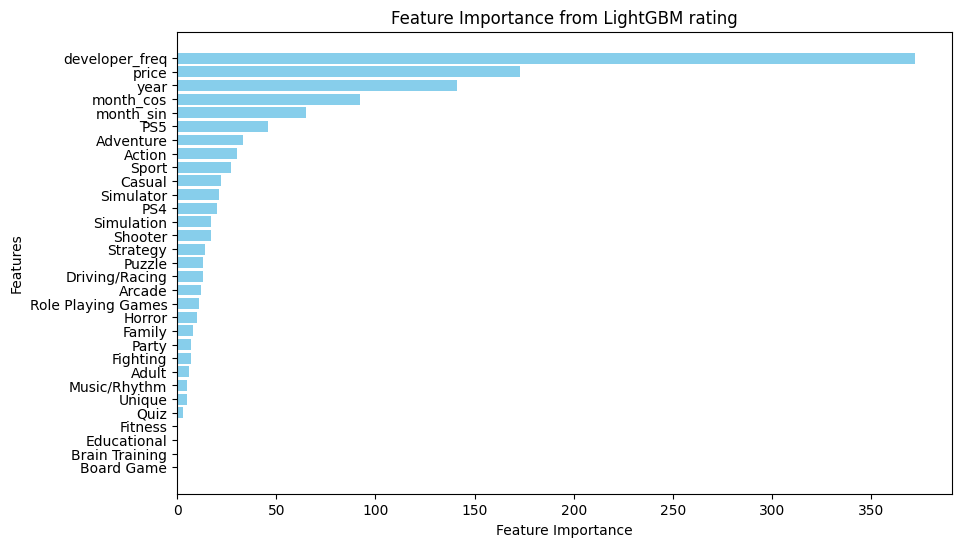

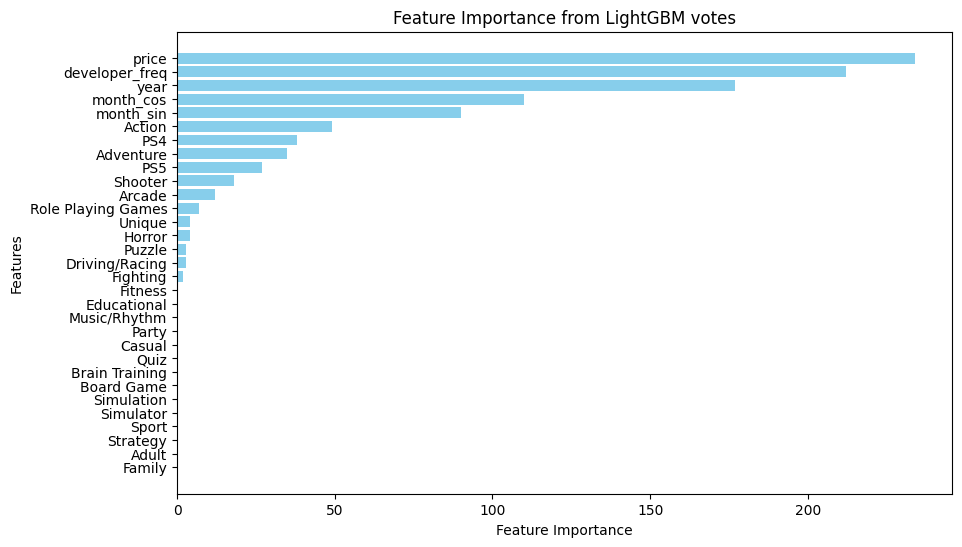

In [35]:
feature_importances_y = model_y.feature_importances_
feature_importances_z = model_z.feature_importances_
feature_names = X_train.columns

importance_y = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_y
}).sort_values(by='Importance', ascending=False)

importance_z = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_z
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_y['Feature'], importance_y['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from LightGBM rating')
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(importance_z['Feature'], importance_z['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from LightGBM votes')
plt.show()

Как и ожидалось самые важные признаки price, dev_freq, monthS, PS_4, Ps_5, year (на самом деле для votes корреляция с этим призанакми маленькая, но корелляция это же не всегда зависимость)

Забавно.   Играм Action особенно часто оставляют отзывы (и корр с этим признаком большая) (может быть так как они вызвают больше эмоций, выливающихся в отзыв) (так же как Shooter и Adventure) Ёще одно объяснение, что объектов обладающих этими призаков просто больше, но это не обясняет, например, разницу в важности Action в почти два раза при предскаазнии rating и votes.


